--- Loading Pre-processed Feature Data ---
Features for 71,219 wallets loaded successfully.

--- PHASE 1: Calculating Scores using Rule-Based System ---
Rule-based scores calculated successfully.

--- PHASE 2: Analysis of Overall Score Distribution ---
Descriptive Statistics for All Rule-Based Scores:


count    71219.000000
mean        77.591443
std         19.696215
min         10.000000
25%         75.000000
50%         80.000000
75%         90.000000
max        100.000000
Name: rule_based_score, dtype: float64

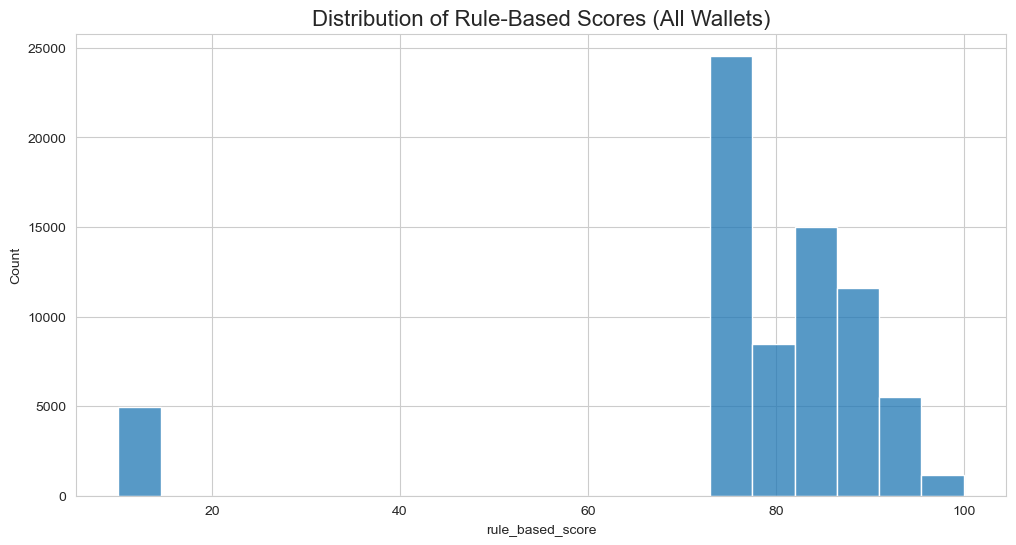


--- PHASE 3: Evaluating the Model's Separation Power ---
Evaluating how well the rule-based score separates our high-confidence archetypes.

--- Statistics for 'Liquidity Provider' Archetype ---


count    2039.000000
mean       76.444335
std        31.985886
min        10.000000
25%        85.000000
50%        90.000000
75%        90.000000
max       100.000000
Name: rule_based_score, dtype: float64


--- Statistics for 'Liquidity Taker' Archetype ---


count    6741.000000
mean       73.284379
std        14.878758
min        10.000000
25%        75.000000
50%        75.000000
75%        80.000000
max        80.000000
Name: rule_based_score, dtype: float64

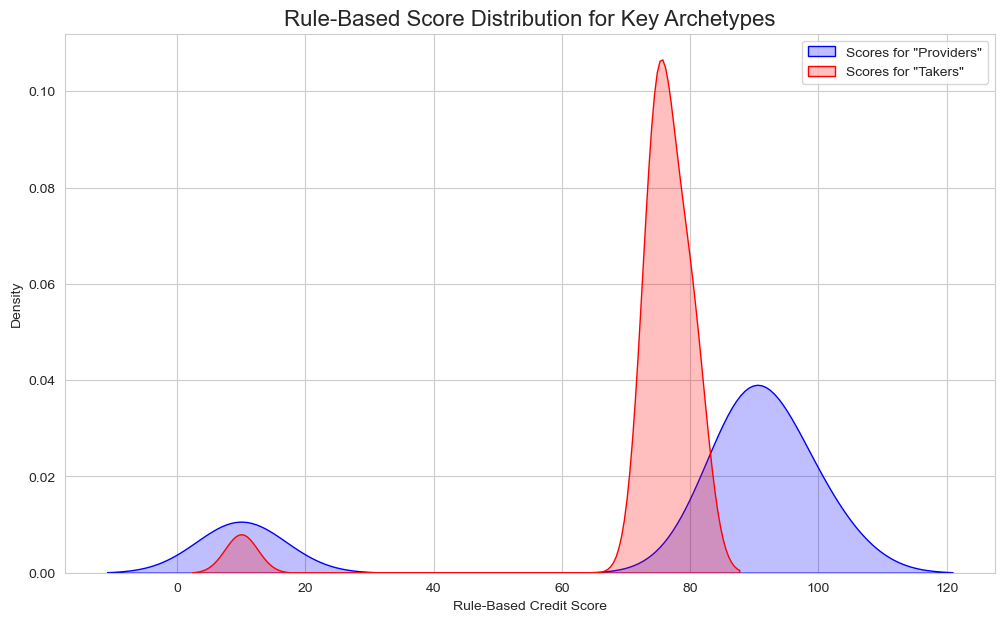


--- BASELINE EVALUATION METRIC ---
Separation Power: 100.00% of 'Takers' have a score lower than the median 'Provider' score.
This provides a quantitative baseline to compare against the ML models.


In [ ]:

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

print("--- Loading Pre-processed Feature Data ---")
try:
    processed_data_path = '../processed_data/wallet_features.pkl'
    wallet_features = pd.read_pickle(processed_data_path)
    print(f"Features for {len(wallet_features):,} wallets loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError("The file 'wallet_features.pkl' was not found. Please run '01_Feature_Engineering.ipynb' first.")

print("\n--- PHASE 1: Calculating Scores using Rule-Based System ---")
base_score = 50
rule_never_liquidated = (wallet_features['is_liquidated'] == 0)
rule_good_repayment = (wallet_features['repay_borrow_ratio_usd'] >= 0.95)
rule_net_depositor = (wallet_features['net_deposit_usd'] > 0)
rule_has_history = (wallet_features['wallet_age_days'] > 60)
score = (
    base_score
    + rule_never_liquidated * 25
    + rule_good_repayment * 15
    + rule_net_depositor * 10
    + rule_has_history * 5
)
score.loc[wallet_features['is_liquidated'] == 1] = 10
wallet_features['rule_based_score'] = np.clip(score, 0, 100).round(2)
print("Rule-based scores calculated successfully.")


print("\n--- PHASE 2: Analysis of Overall Score Distribution ---")
print("Descriptive Statistics for All Rule-Based Scores:")
display(wallet_features['rule_based_score'].describe())
plt.figure(figsize=(12, 6))
sns.histplot(wallet_features['rule_based_score'], bins=20, kde=False)
plt.title('Distribution of Rule-Based Scores (All Wallets)', fontsize=16)
plt.show()


print("\n--- PHASE 3: Evaluating the Model's Separation Power ---")
print("Evaluating how well the rule-based score separates our high-confidence archetypes.")

good_archetype = (
    (wallet_features['net_deposit_usd'] > 1000) & 
    (wallet_features['wallet_age_days'] > 30)
)
bad_archetype = (
    (wallet_features['net_deposit_usd'] < -1000) &
    (wallet_features['repay_borrow_ratio_usd'] < 0.9)
)

eval_df = wallet_features[['rule_based_score']].copy()
eval_df['archetype'] = 'Neutral'
eval_df.loc[good_archetype, 'archetype'] = 'Liquidity Provider'
eval_df.loc[bad_archetype, 'archetype'] = 'Liquidity Taker'

provider_scores = eval_df[eval_df['archetype'] == 'Liquidity Provider']['rule_based_score']
taker_scores = eval_df[eval_df['archetype'] == 'Liquidity Taker']['rule_based_score']

print("\n--- Statistics for 'Liquidity Provider' Archetype ---")
display(provider_scores.describe())
print("\n--- Statistics for 'Liquidity Taker' Archetype ---")
display(taker_scores.describe())

plt.figure(figsize=(12, 7))
sns.kdeplot(provider_scores, fill=True, label='Scores for "Providers"', color='blue')
sns.kdeplot(taker_scores, fill=True, label='Scores for "Takers"', color='red')
plt.title('Rule-Based Score Distribution for Key Archetypes', fontsize=16)
plt.xlabel('Rule-Based Credit Score')
plt.ylabel('Density')
plt.legend()
plt.show()

if not provider_scores.empty and not taker_scores.empty:
    median_provider_score = provider_scores.median()
    separation_accuracy = (taker_scores < median_provider_score).mean()
    print("\n--- BASELINE EVALUATION METRIC ---")
    print(f"Separation Power: {separation_accuracy:.2%} of 'Takers' have a score lower than the median 'Provider' score.")
    print("This provides a quantitative baseline to compare against the ML models.")
else:
    print("\nCould not calculate separation power as one or both archetypes were not found in the data.")